In [199]:
#Загрузим необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import re

In [2]:
#Исходные данные: x - расходы на рекламу, Y - объемы продаж
x = np.array([39, 36, 60, 21, 27, 12, 51, 57, 54, 42, 18, 9, 48, 66, 6, 30, 24, 33, 15, 21]).reshape(20, 1)
Y = np.array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]).reshape(20, 1)
display(x, Y)


array([[39],
       [36],
       [60],
       [21],
       [27],
       [12],
       [51],
       [57],
       [54],
       [42],
       [18],
       [ 9],
       [48],
       [66],
       [ 6],
       [30],
       [24],
       [33],
       [15],
       [21]])

array([[1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0]])

Реализовать класс модели логистической регрессии с использованием:
а) максимизации логарифмического правдоподобия методом градиентного подъема
б) минимизации функции потерь (кросс-энтропии) методом градиентного спуска

Сравнить результаты (время исполнения и достигнутые значения accuracy и f1) в случаях а и б при одном и том же числе шагов и скорости обучения.



а) **Максимизация логарифмического правдоподобия методом градиентного подъема:**

Это означает, что мы хотим настроить параметры модели таким образом, чтобы *максимизировать логарифмическое правдоподобие* нашей модели. Логарифмическое правдоподобие является мерой того, *насколько хорошо модель соответствует данным*.

*Метод градиентного подъема* - это итеративный алгоритм оптимизации, который используется для настройки параметров модели путем изменения их в направлении градиента функции, которую мы хотим оптимизировать (в данном случае, логарифмического правдоподобия). При максимизации *мы ищем направление роста функции*.

image.png


θ - это вектор параметров модели,
X - матрица входных данных,
Y - истинные метки,
^
Y - предсказанные вероятности.

б) **Минимизация функции потерь (кросс-энтропии) методом градиентного спуска:**

Здесь мы хотим *минимизировать функцию потерь*, которая в данном случае является кросс-энтропией. Кросс-энтропия - это мера расхождения между двумя вероятностными распределениями (в данном случае, предсказанными вероятностями модели и истинными метками классов).

*Метод градиентного спуска* - это также итеративный алгоритм оптимизации, который настраивает параметры модели, минимизируя функцию потерь. В данном случае, при минимизации кросс-энтропии, *мы ищем направление убывания функции*.

image.png

f1 score

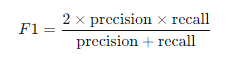

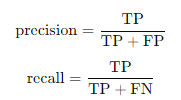

In [301]:
#Реализуем цикл градиентного спуска
class LogisticRegressionGD(object):
    def __init__(self):
        self.a = None  # вектор весов


    def sigmoid(self, z):
        '''Сигмоидная функция, используемая для преобразования
        линейной комбинации входных данных и весов в вероятность'''
        return 1/(1 + np.exp(-z))


    def predict(self, x):
        return self.sigmoid(np.matmul(x , self.a))


    def coefs(self):
        '''Метод, возвращающий веса модели'''
        return self.a


    def LogLikelihood(self, x, Y):
        '''Метод, вычисляющий логарифмическое правдоподобие модели'''
        return (np.matmul(np.transpose(Y), np.log(self.predict(x) + 1e-8)) + np.matmul(np.ones((1, Y.shape[0])) - np.transpose(Y),
                np.log(np.ones((Y.shape[0], 1)) - self.predict(x) + 1e-8)))[0][0]


    def CrossEntropy(self, x, Y):
        '''Метод, вычисляющий кросс-энтропию'''
        return (np.matmul(np.transpose(Y), np.log(self.predict(x) + 1e-8)) - np.matmul(np.ones((1, Y.shape[0])) - np.transpose(Y),
                np.log(np.ones((Y.shape[0], 1)) - self.predict(x) + 1e-8)))[0][0]


    def accuracy(self, x, Y):
        '''Метод, вычисляющий точность модели на данных'''
        return (Y == self.predict(x)).mean()


    def f1_score(self, y_true, y_pred):
      '''Функция для вычисления F1-меры'''
      tp = np.sum((y_true == 1) & (y_pred == 1))  # количество истинно положительных
      fp = np.sum((y_true == 0) & (y_pred == 1))  # количество ложно положительных
      fn = np.sum((y_true == 1) & (y_pred == 0))  # количество ложно отрицательных

      precision = tp / (tp + fp + 1e-8)  # точность
      recall = tp / (tp + fn + 1e-8)     # полнота

      f1 = 2 * (precision * recall) / (precision + recall + 1e-8)  # F1-мера

      return f1


    def fit(self, x, Y, alpha = 0.001, epsylon = 0.001, max_steps = 5000, Rtype = "LL"):
        '''Метод, выполняющий обучение модели'''
        self.a = np.zeros(x.shape[1]).reshape(x.shape[1],1)
        steps, errors = [], []
        step = 0
        for _ in range(max_steps):
            '''Выполняются итерации градиентного спуска или градиентного подъема
             в зависимости от выбранного типа функции потерь'''

            if Rtype == "LL":  # максимизации логарифмического правдоподобия
                new_error = self.LogLikelihood(x, Y) # определяем текущее значение логарифмического правдоподобия
                dT_a = np.matmul(np.transpose(x), Y - self.predict(x))  # вычисляем градиент функции логарифмического правдоподобия по весам модели
                self.a += alpha*dT_a  # обновляем веса

            elif Rtype == "CE":  # минимизация кросс-энтропии
                new_error = self.CrossEntropy(x, Y)  #  определяем текущее значение кросс-энтропии
                dT_a = -np.matmul(np.transpose(x), Y - self.predict(x))  # вычисляем градиент функции кросс-энтропии по весам модели
                self.a -= alpha*dT_a  # обновляем веса модели, двигаясь в направлении антиградиента

            step += 1
            steps.append(step)
            errors.append(new_error)

            if abs(new_error) < epsylon:
                break

        return steps, errors

### Реализовать класс модели логистической регрессии с использованием: а) максимизации логарифмического правдоподобия методом градиентного подъема

In [13]:
x_ = x.copy()

intercept = np.ones((x.shape[0], 1))
x_ = np.concatenate((intercept, x), axis = 1)

In [14]:
start_time = time.time()
regr1 = LogisticRegressionGD()
steps, errors =  regr1.fit(x_, Y, alpha = 0.0005, epsylon = 0.001, max_steps = 20000, Rtype = "LL")

print(f"Время обучения: {round(time.time() - start_time, 3)} сек")

Время обучения: 1.588 сек


array([[-4.0015722 ],
       [ 0.12327176]])

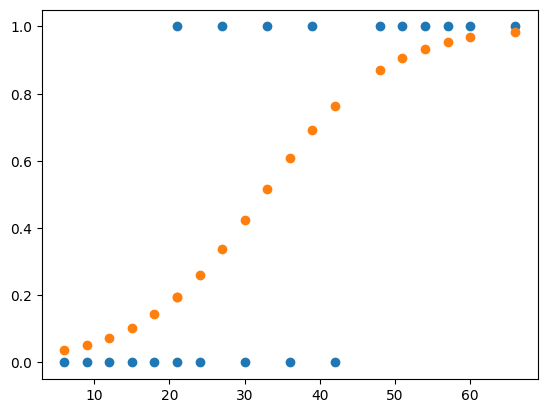

In [15]:
display(regr1.coefs())

Y_pred = regr1.predict(x_)

plt.scatter(x, Y)
plt.scatter(x, Y_pred)

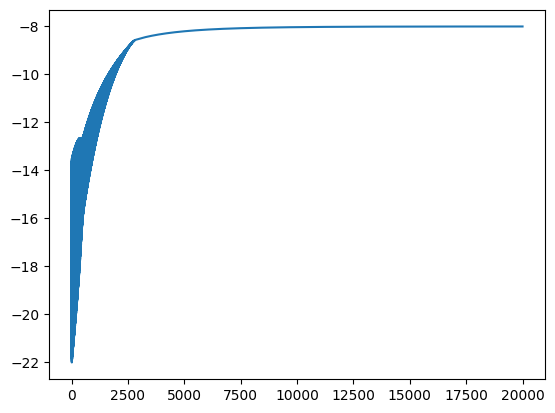

In [7]:
plt.plot(steps, errors)

### Реализовать класс модели логистической регрессии с использованием: б) минимизации функции потерь (кросс-энтропии) методом градиентного спуска

In [8]:
x_ = x.copy()

intercept = np.ones((x.shape[0], 1))
x_ = np.concatenate((intercept, x), axis = 1)

In [9]:
start_time = time.time()
regr2 = LogisticRegressionGD()
steps, errors =  regr2.fit(x_, Y, alpha = 0.0005, epsylon = 0.001, max_steps = 20000, Rtype = "CE")

print(f"Время обучения: {round(time.time() - start_time, 3)} сек")

Время обучения: 0.0 сек


array([[0.     ],
       [0.06075]])

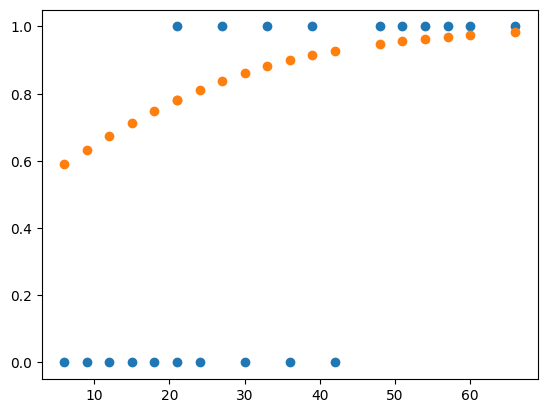

In [10]:
display(regr2.coefs())

Y_Pred = regr2.predict(x_)

plt.scatter(x, Y)
plt.scatter(x, Y_Pred)

Реализовать расчеты способами а и б для набора данных из файла insclass_train.csv/

Для 151 406 договоров страхования транспортных средств известны значения ряда признаков, в том числе пол, возраст, стаж вождения и коэффициент бонус-малус водителя, тип, марка, модель, год выпуска, страна – производитель, мощность и объем двигателя, а также признак target, равный 1, если заключение договора с клиентом является рисковым, и 0 в противном случае (файл insclass_train.csv).

Требуется построить модель, предсказывающую значение признака target для 22 624 договоров из тестового набора данных (файл insclass_test.csv).

В обучающем наборе данных для каждого договора известны следующие поля:

variable_1 - агрегированный коэффициент бонус-малус (повышающий или понижающий стоимость полиса в зависимости от аварийности в предыдущие периоды);

variable_2 - индикатор расторжения договора по инициативе страхователя (клиента);

variable_3 - индикатор расторжения договора по инициативе страховщика (страховой компании);

variable_4 - идентификатор года выпуска транспортного средства;

variable_5 - идентификатор страны - производителя транспортного средства;

variable_6 - мощность двигателя в лошадиных силах;

variable_7 - объем двигателя в куб. см;

variable_8 - идентификатор стороны расположения руля (левый или правый);

variable_9 - пробег транспортного средства, покрываемый гарантией производителя;

variable_10 - индикатор действия гарантии на транспортное средство;

variable_11 - "мультидрайв" - индикатор допуска к управлению транспортным средством более одного водителя;

variable_12 - возраст транспортного средства (в мес.);

variable_13 - возраст водителя с максимальным стажем;

variable_14 - коэффициент возраст-стаж;

variable_15 - коэффициент краткосрочности;

variable_16 - коэффициент мощности;

variable_17 - коэффициент "мультидрайв";

variable_18 - территориальный коэффициент;

variable_19 - коэффициент "КНДР";

variable_20 - идентификатор канала продаж;

variable_21 - марка транспортного средства;

variable_22 - модель транспортного средства;

variable_23 - индикатор отечественных транспортных средств;

variable_24 - пол водителя с максимальным коэффициентом "возраст-стаж";

variable_25 - индикатор пролонгации;

variable_26 - индикатор совпадения собственника транспортного средства и водителя;

variable_27 - стаж водителя с максимальным коэффициентом "возраст-стаж";

variable_28 - тип транспортного средства;

target - класс риска, равный 1, если заключение договора с клиентом является рисковым, и 0 в противном случае.

### Загрузка датасета

In [201]:
# Подключаемся с google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [220]:
# Загружаем файл CSV в DataFrame
df = pd.read_csv("/content/drive/MyDrive/ОЗМО/insclass_train.csv")

df.sample(5)

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,variable_10,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
94070,w200,0,0,11,q4,87.0,NaN,0.0,NaN,0,...,C,j7,h31,0,1.0,0,1,13.635261,t1,0
26166,w160,0,0,26,q0,149.0,1760.0,0.0,NaN,0,...,C,j52,h360,0,1.0,0,1,19.323463,t1,0
142016,w200,0,0,26,q2,85.0,NaN,0.0,NaN,0,...,B,j2,h117,0,1.0,0,0,7.883271,t1,0
91762,w160,0,0,14,q2,115.0,NaN,0.0,NaN,0,...,B,j2,h45,0,1.0,0,1,15.065199,t1,0
130912,w160,0,0,6,q1,101.0,NaN,0.0,NaN,0,...,C,j1,h1,0,1.0,0,0,23.530077,t1,0


### Анализ данных

In [203]:
# Информация о типах данных и пропущенных значениях
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151406 entries, 0 to 151405
Data columns (total 29 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   variable_1   151406 non-null  object 
 1   variable_2   151406 non-null  int64  
 2   variable_3   151406 non-null  int64  
 3   variable_4   151406 non-null  int64  
 4   variable_5   151406 non-null  object 
 5   variable_6   151295 non-null  float64
 6   variable_7   55767 non-null   float64
 7   variable_8   121507 non-null  float64
 8   variable_9   16970 non-null   float64
 9   variable_10  151406 non-null  int64  
 10  variable_11  151406 non-null  int64  
 11  variable_12  149878 non-null  float64
 12  variable_13  149749 non-null  float64
 13  variable_14  148479 non-null  float64
 14  variable_15  13 non-null      float64
 15  variable_16  151394 non-null  float64
 16  variable_17  151394 non-null  float64
 17  variable_18  151394 non-null  float64
 18  variable_19  151406 non-

In [18]:
# Основные статистические показатели
df.describe()

,variable_2,variable_3,variable_4,variable_6,variable_7,variable_8,variable_9,variable_10,variable_11,variable_12,...,variable_16,variable_17,variable_18,variable_19,variable_23,variable_24,variable_25,variable_26,variable_27,target
count,151406.000000,151406.0,151406.000000,151295.000000,55767.000000,121507.000000,1.697000e+04,151406.000000,151406.000000,149878.000000,...,151394.000000,151394.000000,151394.000000,151406.000000,151406.000000,149199.000000,151406.000000,151406.000000,149339.000000,151406.000000
mean,0.017047,0.0,11.307676,117.937741,1865.909732,0.000337,3.459045e+32,0.017364,0.019537,133.099956,...,132.273151,85.507594,109.164414,139.913519,0.201769,0.737096,0.097612,0.862562,15.551271,0.095498
std,0.129446,0.0,6.925851,50.334055,848.398846,0.018366,4.506062e+34,0.130624,0.138403,87.881579,...,42.465123,29.151078,67.577224,18.585624,0.401322,0.440212,0.296790,0.344311,12.004247,0.293903
min,0.000000,0.0,2.000000,1.000000,1.000000,0.000000,-2.191600e+04,0.000000,0.000000,0.000000,...,28.130592,80.985224,19.287400,102.172584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,6.000000,86.000000,1499.000000,0.000000,7.808400e+04,0.000000,0.000000,66.827923,...,98.648082,80.985224,65.116010,127.113159,0.000000,0.000000,0.000000,1.000000,6.447149,0.000000
50%,0.000000,0.0,10.000000,107.000000,1598.000000,0.000000,1.000000e+05,0.000000,0.000000,121.261910,...,118.116608,80.985224,80.985224,131.419341,0.000000,1.000000,0.000000,1.000000,12.200897,0.000000
75%,0.000000,0.0,14.000000,137.000000,1998.000000,0.000000,1.000000e+05,0.000000,0.000000,175.818287,...,162.514016,80.985224,139.401847,148.905712,0.000000,1.000000,0.000000,1.000000,20.731525,0.000000
max,1.000000,0.0,80.000000,1975.000000,35697.000000,1.000000,5.870000e+36,1.000000,1.000000,842.774591,...,214.256572,273.413449,376.183487,284.372991,1.000000,1.000000,1.000000,1.000000,100.563999,1.000000


Можно рассмотреть удаление некоторых столбцов на основании представленных статистических данных. Например:

Столбцы с высоким процентом отсутствующих значений, такие как **variable_7**, **variable_9** и **variable_15**. В них отсутствует более 90% данных, что делает их менее информативными для обучения модели.

Столбцы с малой дисперсией значений, где стандартное отклонение близко к нулю, например, **variable_3** и **variable_10**. Это может указывать на то, что эти признаки имеют почти одинаковые значения для всех записей, что не приносит значительного вклада в модель.

Столбцы с одинаковыми значениями для всех записей, например, **variable_19** и **variable_25**, где стандартное отклонение равно нулю. Эти признаки не предоставляют информации для разделения данных и могут быть удалены.

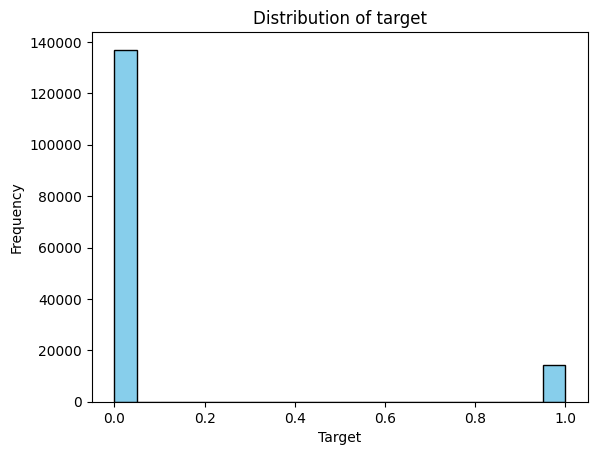

In [221]:
import matplotlib.pyplot as plt

# Построение гистограммы распределения целевой переменной
plt.hist(df['target'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of target')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

### Предобработка даных

#### Обработка пропущенных значений

In [222]:
# Посмотрим на количество пропущенных значений в каждом столбце
print(df.isnull().sum())

variable_1          0
variable_2          0
variable_3          0
variable_4          0
variable_5          0
variable_6        111
variable_7      95639
variable_8      29899
variable_9     134436
variable_10         0
variable_11         0
variable_12      1528
variable_13      1657
variable_14      2927
variable_15    151393
variable_16        12
variable_17        12
variable_18        12
variable_19         0
variable_20         1
variable_21         0
variable_22         0
variable_23         0
variable_24      2207
variable_25         0
variable_26         0
variable_27      2067
variable_28         0
target              0
dtype: int64


In [223]:
# Удаление столбцов с высоким процентом отсутствующих значений
df.dropna(thresh=len(df) * 0.3, axis=1, inplace=True)

In [224]:
df.sample(5)

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
138945,w145,0,0,6,q4,84.0,1598.0,0.0,0,0,...,C,j7,h31,0,1.0,0,1,13.635261,t1,0
147596,w200,0,0,6,q0,109.0,1600.0,0.0,0,0,...,B,j3,h50,0,0.0,0,1,2.249316,t1,0
3109,w200,0,0,6,q0,110.0,1598.0,0.0,0,0,...,C,j2,h103,0,1.0,0,1,6.447149,t1,0
34285,w200,0,0,10,q3,145.0,2497.0,0.0,0,0,...,C,j12,h104,0,1.0,0,1,19.323463,t1,0
105227,w200,0,0,13,q4,100.0,2445.0,NaN,0,0,...,A,j9,h12,1,1.0,0,1,0.975189,t1,0


In [225]:
columns_to_keep_digits = ['variable_1', 'variable_5', 'variable_21', 'variable_22', 'variable_28']

for column in columns_to_keep_digits:
    df[column] = df[column].str.replace(r'\D', '', regex=True).astype(int)

In [226]:
df.sample(5)

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
211,200,0,0,46,0,81.0,NaN,0.0,0,0,...,C,37,60,1,1.0,1,1,5.020658,5,0
52162,145,0,0,10,7,100.0,NaN,0.0,0,0,...,C,11,58,0,1.0,0,1,7.883271,1,0
99348,333,0,0,10,7,100.0,NaN,0.0,0,0,...,C,11,58,0,1.0,0,1,22.133735,1,0
108523,200,0,0,15,4,33.0,NaN,0.0,0,0,...,C,6,311,1,1.0,0,0,7.883271,1,0
46557,160,0,0,14,4,80.0,NaN,0.0,0,0,...,C,3,49,0,1.0,0,1,13.635261,1,0


In [227]:
# Информация о типах данных и пропущенных значениях
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151406 entries, 0 to 151405
Data columns (total 27 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   variable_1   151406 non-null  int64  
 1   variable_2   151406 non-null  int64  
 2   variable_3   151406 non-null  int64  
 3   variable_4   151406 non-null  int64  
 4   variable_5   151406 non-null  int64  
 5   variable_6   151295 non-null  float64
 6   variable_7   55767 non-null   float64
 7   variable_8   121507 non-null  float64
 8   variable_10  151406 non-null  int64  
 9   variable_11  151406 non-null  int64  
 10  variable_12  149878 non-null  float64
 11  variable_13  149749 non-null  float64
 12  variable_14  148479 non-null  float64
 13  variable_16  151394 non-null  float64
 14  variable_17  151394 non-null  float64
 15  variable_18  151394 non-null  float64
 16  variable_19  151406 non-null  float64
 17  variable_20  151405 non-null  object 
 18  variable_21  151406 non-

In [228]:
# Заполним пропущенные значения в числовых столбцах средними значениями
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

In [236]:
# Заполним пропущенные значения в категориальных столбцах модой
categorical_cols = ['variable_1', 'variable_5', 'variable_20', 'variable_21', 'variable_22', 'variable_28']
print(categorical_cols)
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

['variable_1', 'variable_5', 'variable_20', 'variable_21', 'variable_22', 'variable_28']


In [237]:
df.drop('variable_3', axis=1, inplace=True)

In [238]:
print(df.isnull().sum())

variable_1     0
variable_2     0
variable_4     0
variable_5     0
variable_6     0
variable_7     0
variable_8     0
variable_10    0
variable_11    0
variable_12    0
variable_13    0
variable_14    0
variable_16    0
variable_17    0
variable_18    0
variable_19    0
variable_20    0
variable_21    0
variable_22    0
variable_23    0
variable_24    0
variable_25    0
variable_26    0
variable_27    0
variable_28    0
target         0
dtype: int64


In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151406 entries, 0 to 151405
Data columns (total 26 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   variable_1   151406 non-null  int64 
 1   variable_2   151406 non-null  int64 
 2   variable_4   151406 non-null  int64 
 3   variable_5   151406 non-null  int64 
 4   variable_6   151406 non-null  int64 
 5   variable_7   151406 non-null  int64 
 6   variable_8   151406 non-null  int64 
 7   variable_10  151406 non-null  int64 
 8   variable_11  151406 non-null  int64 
 9   variable_12  151406 non-null  int64 
 10  variable_13  151406 non-null  int64 
 11  variable_14  151406 non-null  int64 
 12  variable_16  151406 non-null  int64 
 13  variable_17  151406 non-null  int64 
 14  variable_18  151406 non-null  int64 
 15  variable_19  151406 non-null  int64 
 16  variable_20  151406 non-null  object
 17  variable_21  151406 non-null  int64 
 18  variable_22  151406 non-null  int64 
 19  va

In [240]:
# Основные статистические показатели
df.describe()

,variable_1,variable_2,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,variable_12,...,variable_19,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
count,151406.000000,151406.000000,151406.000000,151406.000000,151406.000000,151406.000000,151406.000000,151406.000000,151406.000000,151406.000000,...,151406.000000,151406.000000,151406.000000,151406.000000,151406.000000,151406.000000,151406.000000,151406.000000,151406.000000,151406.000000
mean,169.501096,0.017047,11.307676,3.579013,117.937741,1865.909732,0.000337,0.017364,0.019537,133.099956,...,139.913519,13.450273,148.105234,0.201769,0.737096,0.097612,0.862562,15.551271,1.017668,0.095498
std,97.223796,0.129446,6.925851,3.648023,50.315601,514.890297,0.016453,0.130624,0.138403,87.436998,...,18.585624,15.762812,207.246511,0.401322,0.436992,0.296790,0.344311,11.922024,0.210985,0.293903
min,2.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,102.172584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,160.000000,0.000000,6.000000,1.000000,86.000000,1840.000000,0.000000,0.000000,0.000000,66.827923,...,127.113159,4.000000,28.000000,0.000000,0.000000,0.000000,1.000000,6.447149,1.000000,0.000000
50%,160.000000,0.000000,10.000000,3.000000,107.000000,1865.909732,0.000000,0.000000,0.000000,122.392869,...,131.419341,9.000000,64.000000,0.000000,1.000000,0.000000,1.000000,12.200897,1.000000,0.000000
75%,200.000000,0.000000,14.000000,4.000000,137.000000,1865.909732,0.000000,0.000000,0.000000,175.818287,...,148.905712,15.000000,174.000000,0.000000,1.000000,0.000000,1.000000,20.731525,1.000000,0.000000
max,1067.000000,1.000000,80.000000,41.000000,1975.000000,35697.000000,1.000000,1.000000,1.000000,842.774591,...,284.372991,230.000000,1736.000000,1.000000,1.000000,1.000000,1.000000,100.563999,5.000000,1.000000


#### Кодирование категориальных признаков

In [241]:
def create_dummy_variables(df, column_name):
    # Получаем уникальные значения из столбца
    unique_values = df[column_name].unique()

    # Создаем новый DataFrame для хранения dummy переменных
    dummy_df = pd.DataFrame(index=df.index)

    # Создаем dummy переменные для каждого уникального значения
    for value in unique_values:
        dummy_df[f'{column_name}_{value}'] = (df[column_name] == value).astype(int)

    return dummy_df

In [244]:
categorical_cols = ['variable_20']

In [245]:
encoded_dfs = []
for col in categorical_cols:
    encoded_df = create_dummy_variables(df, col)
    encoded_dfs.append(encoded_df)

In [246]:
# Объединим dummy переменные с исходным DataFrame
df_encoded = pd.concat([df] + encoded_dfs, axis=1)

In [247]:
# Удалим исходные категориальные столбцы, так как теперь у нас есть dummy переменные
df_encoded.drop(categorical_cols, axis=1, inplace=True)

In [248]:
df_encoded.sample(5)

,variable_1,variable_2,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,variable_12,...,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target,variable_20_C,variable_20_B,variable_20_A
31929,160,0,21,4,72.0,1865.909732,0.000000,0,0,262.662504,...,1,1.0,0,1,24.920571,1,0,1,0,0
78305,200,0,7,0,140.0,1796.000000,0.000000,0,0,82.756867,...,0,0.0,0,1,10.763031,1,0,1,0,0
81588,200,0,5,1,122.0,1865.909732,0.000000,0,0,52.915733,...,0,1.0,0,1,3.614395,1,0,1,0,0
7479,200,0,11,4,87.0,1865.909732,0.000000,0,0,139.143259,...,0,1.0,0,1,6.447149,1,0,1,0,0
36874,200,0,18,1,115.0,1984.000000,0.000337,0,0,211.029675,...,0,0.0,0,1,0.000000,1,0,0,0,1


In [249]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151406 entries, 0 to 151405
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   variable_1     151406 non-null  int64  
 1   variable_2     151406 non-null  int64  
 2   variable_4     151406 non-null  int64  
 3   variable_5     151406 non-null  int64  
 4   variable_6     151406 non-null  float64
 5   variable_7     151406 non-null  float64
 6   variable_8     151406 non-null  float64
 7   variable_10    151406 non-null  int64  
 8   variable_11    151406 non-null  int64  
 9   variable_12    151406 non-null  float64
 10  variable_13    151406 non-null  float64
 11  variable_14    151406 non-null  float64
 12  variable_16    151406 non-null  float64
 13  variable_17    151406 non-null  float64
 14  variable_18    151406 non-null  float64
 15  variable_19    151406 non-null  float64
 16  variable_21    151406 non-null  int64  
 17  variable_22    151406 non-nul

#### StandardScaler не категориальных признаков

In [250]:
def StandardScaler(df):
    scaled_df = df.copy()

    means = scaled_df.mean()
    stds = scaled_df.std()

    scaled_df = (scaled_df - means) / stds

    return scaled_df

In [251]:
columns_to_scale = df_encoded.columns.difference(['target', 'variable_20_A', 'variable_20_B', 'variable_20_C'])
scaled_df = StandardScaler(df_encoded[columns_to_scale])
df_scaled = pd.concat([scaled_df, df_encoded[['target', 'variable_20_A', 'variable_20_B', 'variable_20_C']]], axis=1)

In [252]:
df_scaled.sample(5)

,variable_1,variable_10,variable_11,variable_12,variable_13,variable_14,variable_16,variable_17,variable_18,variable_19,...,variable_28,variable_4,variable_5,variable_6,variable_7,variable_8,target,variable_20_A,variable_20_B,variable_20_C
147835,-0.097724,-0.132931,-0.141160,-0.226545,0.686522,-0.208472,-0.791859,-0.155142,-1.042703,0.483825,...,-0.083739,-0.188811,-0.981083,-0.853368,8.831927e-16,-2.050851e-02,0,0,1,0
109033,-1.619985,-0.132931,7.084132,-0.617299,-1.091797,0.000000,1.930683,6.446187,2.430635,0.771098,...,-0.083739,-0.477584,-0.706962,2.247062,2.194818e+00,3.294820e-18,0,0,0,1
57792,-0.097724,-0.132931,-0.141160,-1.221390,0.768312,-0.208472,1.930683,-0.155142,2.430635,0.771098,...,-0.083739,-1.055130,-0.981083,1.233460,8.831927e-16,-2.050851e-02,0,0,1,0
43667,-0.097724,-0.132931,-0.141160,0.031155,-0.570668,-0.208472,0.712162,-0.155142,-0.417009,0.483825,...,-0.083739,-0.044424,-0.158720,0.378854,8.831927e-16,-2.050851e-02,0,0,0,1
34004,0.313698,-0.132931,-0.141160,-0.757940,-1.445990,3.859219,-0.333382,-0.155142,-1.042703,0.483825,...,-0.083739,-0.766357,-0.432841,-0.217383,8.831927e-16,-2.050851e-02,0,0,0,1


### Обучение

In [302]:
def f1_score(y_true, y_pred):
    assert len(y_true) == len(y_pred),

    tp = sum((yt == 0) and (yp == 0) for yt, yp in zip(y_true, y_pred))
    fp = sum((yt == 1) and (yp == 0) for yt, yp in zip(y_true, y_pred))
    fn = sum((yt == 0) and (yp == 1) for yt, yp in zip(y_true, y_pred))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1_score.item()

In [336]:
def train_and_eval(df, rtype):
    # Перемешиваем данные
    df_shuffled = df.sample(frac=1)

    # Разделение на обучающую и тестовую выборки
    train_size = int(0.8 * len(df_shuffled))
    df_train = df_shuffled.iloc[:train_size]
    df_test = df_shuffled.iloc[train_size:]

    # Получаем признаки и метки для обучения
    x_train = np.array(df_train.drop(columns=['target']))
    y_train = np.array(df_train['target']).reshape(x_train.shape[0], 1)

    # Добавляем столбец с единицами для учета свободного члена
    x_train_ = np.concatenate((np.ones((x_train.shape[0], 1)), x_train), axis=1)

    # Получаем признаки и метки для теста
    x_test = np.array(df_test.drop(columns=['target']))
    y_test = np.array(df_test['target']).reshape(x_test.shape[0], 1)

    # Добавляем столбец с единицами для учета свободного члена
    x_test_ = np.concatenate((np.ones((x_test.shape[0], 1)), x_test), axis=1)

    start_time = time.time()
    # Создаем экземпляр класса логистической регрессии
    regr = LogisticRegressionGD()

    # Обучаем модель
    steps, errors =  regr.fit(x_train_, y_train, alpha=0.001, epsylon=0.001, max_steps=5, Rtype=rtype)
    print(f'Время обучения: {time.time() - start_time:.3f} сек.')

    # Вычисляем прогнозы на обучающей выборке
    Y_Pred_train = regr.predict(x_train_)
    print(f'Accuracy on train: {Y_Pred_train[Y_Pred_train == y_train].shape[0] / y_train.shape[0]:.3f}')
    print(f'F1 score on train: {f1_score(y_train, Y_Pred_train):.3f}')

    # Вычисляем прогнозы на тестовой выборке
    Y_Pred_test = regr.predict(x_test_)
    print(f'Accuracy on test: {Y_Pred_test[Y_Pred_test == y_test].shape[0] / y_test.shape[0]:.3f}')
    print(f'F1 score on test: {f1_score(y_test, Y_Pred_test):.3f}')

    return steps, errors

<ipython-input-301-6b3e777934ab>:10: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


Время обучения: 0.065 сек.
Accuracy on train: 0.905
F1 score on train: 0.950
Accuracy on test: 0.904
F1 score on test: 0.949


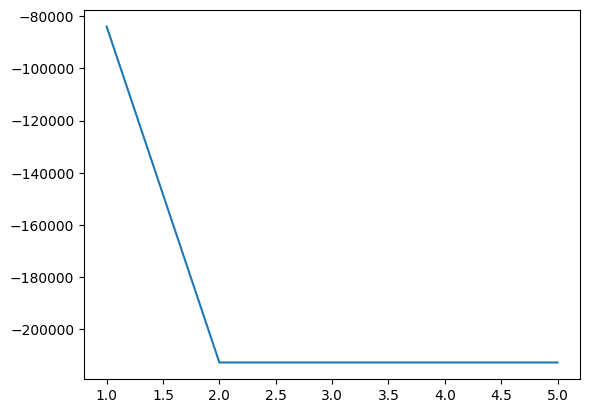

In [341]:
steps, errors = train_and_eval(df_encoded, 'LL')
plt.plot(steps, errors)

<ipython-input-301-6b3e777934ab>:10: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


Время обучения: 0.065 сек.
Accuracy on train: 0.905
F1 score on train: 0.950
Accuracy on test: 0.903
F1 score on test: 0.949


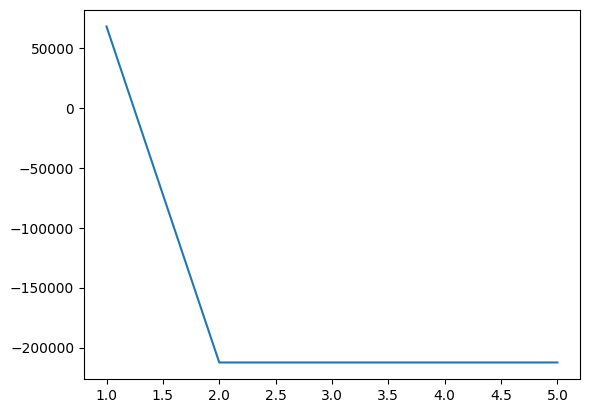

In [331]:
steps, errors = train_and_eval(df_encoded, 'CE')
plt.plot(steps, errors)